# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

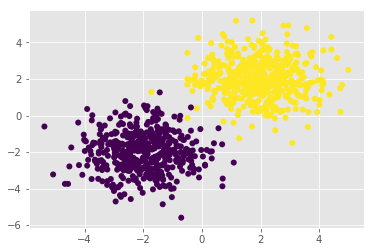

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(SoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

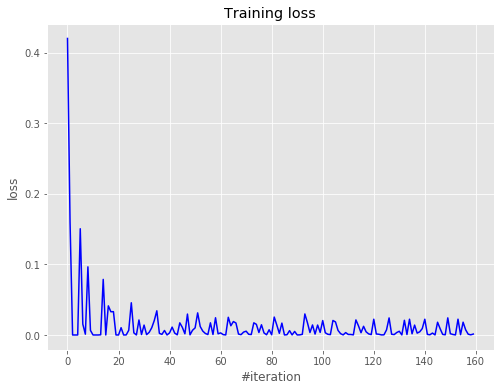

Current loss: 0.001300


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [9]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

In [10]:
X.shape, y.shape

((70000, 784), (70000,))

One-hot encode the labels first.

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
one_hot_y = np.array(enc.fit_transform(y.reshape(-1, 1)).todense())

In [12]:
one_hot_y.shape

(70000, 10)

# Split the data:

In [17]:
from sklearn.cross_validation import train_test_split

##split train 50000, test 20000
##then split test to two parts: validation 10000, test 10000

X_train, X_test, y_train, y_test = train_test_split(X, one_hot_y, test_size=0.2857142857, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)


In [18]:
X_train.shape, X_test.shape, X_val.shape

((50000, 784), (10000, 784), (10000, 784))

In [19]:
y_train.shape, y_test.shape, y_val.shape

((50000, 10), (10000, 10), (10000, 10))

In [20]:
type(X_train)

numpy.ndarray

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

# Accuracy:

In [21]:
def accuracy_score(Y_true, Y_predict):
    res = 0
    for i in range(len(Y_true)):
        if np.argmax(Y_true[i]) == np.argmax(Y_predict[i]):
            res = res+ 1
    return res / len(Y_true)

# Train:

In [22]:
def net_train_(net, n_epoch):
    loss_history = []
    X= X_train
    Y = y_train
    
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches(X, Y, batch_size):
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
        
        net.evaluate()
        print("epoch:",i)
        print('\tloss:   {:.2f}'.format(loss) )
        print('\tAccuracy: train:        {:.2f} %'.format(accuracy_score(net.forward(X_train), y_train) * 100))
        print('\tAccuracy: validation:   {:.2f} %'.format(accuracy_score(net.forward(X_val), y_val) * 100))
            
    
    net.evaluate()
    
    # Visualize
        
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    
        
    return loss_history

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

---

PS: Here you can find many trials, some of them are good, others are bad. You can skip this part until the end to see the summary!

---

In [23]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 5
batch_size = 1500

In [24]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(ReLU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
ReLU
Linear 300 -> 10
SoftMax



epoch: 0
	loss:   0.92
	Accuracy: train:        74.63 %
	Accuracy: validation:   74.44 %
epoch: 1
	loss:   0.92
	Accuracy: train:        80.79 %
	Accuracy: validation:   80.78 %
epoch: 2
	loss:   0.57
	Accuracy: train:        89.45 %
	Accuracy: validation:   89.63 %
epoch: 3
	loss:   0.28
	Accuracy: train:        93.38 %
	Accuracy: validation:   93.41 %
epoch: 4
	loss:   0.23
	Accuracy: train:        94.19 %
	Accuracy: validation:   94.06 %


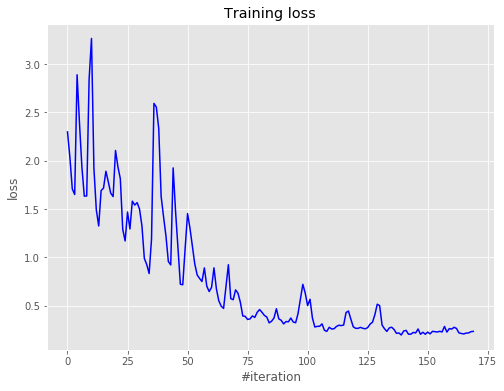

Wall time: 52 s


In [25]:
%%time
batch_size = 1500
net_train_(net, n_epoch)

In [26]:
print('Accuracy on test set:   {:.2f} %'.format(accuracy_score(net.forward(X_test), y_test) * 100))

Accuracy on test set:   94.08 %


*************************

epoch: 0
	loss:   0.16
	Accuracy: train:        94.92 %
	Accuracy: validation:   94.81 %
epoch: 1
	loss:   0.16
	Accuracy: train:        95.35 %
	Accuracy: validation:   95.10 %
epoch: 2
	loss:   0.16
	Accuracy: train:        95.68 %
	Accuracy: validation:   95.28 %
epoch: 3
	loss:   0.14
	Accuracy: train:        96.09 %
	Accuracy: validation:   95.68 %
epoch: 4
	loss:   0.13
	Accuracy: train:        96.31 %
	Accuracy: validation:   95.96 %


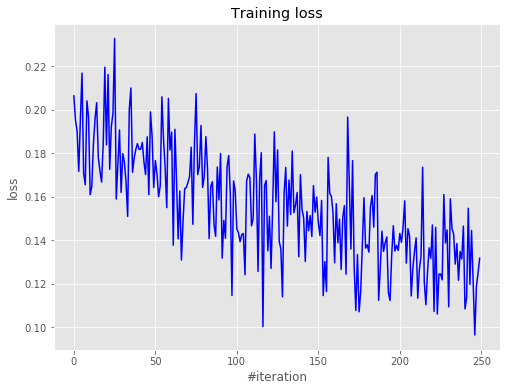

Wall time: 52.4 s


In [27]:
%%time
batch_size = 1000
net_train_(net, n_epoch)

In [28]:
print('Accuracy on test set:   {:.2f} %'.format(accuracy_score(net.forward(X_test), y_test) * 100))

Accuracy on test set:   95.76 %


*************

epoch: 0
	loss:   0.14
	Accuracy: train:        96.58 %
	Accuracy: validation:   96.01 %
epoch: 1
	loss:   0.14
	Accuracy: train:        96.76 %
	Accuracy: validation:   96.19 %
epoch: 2
	loss:   0.11
	Accuracy: train:        97.07 %
	Accuracy: validation:   96.53 %
epoch: 3
	loss:   0.12
	Accuracy: train:        97.17 %
	Accuracy: validation:   96.59 %
epoch: 4
	loss:   0.07
	Accuracy: train:        97.32 %
	Accuracy: validation:   96.74 %


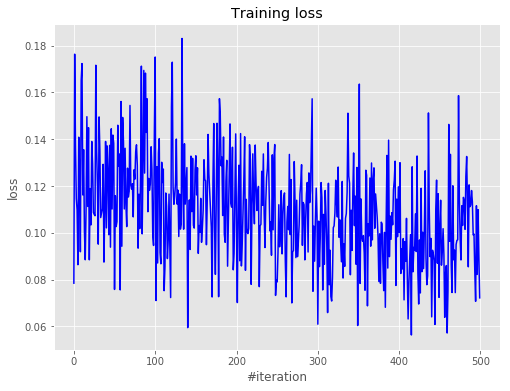

Wall time: 59.7 s


In [29]:
%%time
batch_size = 500
loss_history = net_train_(net, n_epoch)

In [30]:
print('Accuracy on test set:   {:.2f} %'.format(accuracy_score(net.forward(X_test), y_test) * 100))

Accuracy on test set:   96.39 %


******************

Batch size 1000 seems good

Now let's change our net

******************

In [106]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(ELU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
ELU
Linear 300 -> 10
SoftMax



epoch: 0
	loss:   10.04
	Accuracy: train:        58.29 %
	Accuracy: validation:   57.98 %
epoch: 1
	loss:   4.06
	Accuracy: train:        77.17 %
	Accuracy: validation:   77.46 %
epoch: 2
	loss:   3.34
	Accuracy: train:        84.96 %
	Accuracy: validation:   85.27 %
epoch: 3
	loss:   3.41
	Accuracy: train:        85.79 %
	Accuracy: validation:   85.87 %
epoch: 4
	loss:   3.98
	Accuracy: train:        86.05 %
	Accuracy: validation:   85.98 %


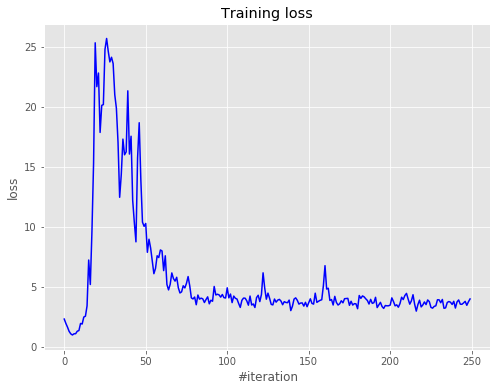

Wall time: 1min


In [107]:
%%time
batch_size = 1000
net_train_(net, n_epoch)

In [109]:
print('Accuracy on test set:   {:.2f} %'.format(accuracy_score(net.forward(X_test), y_test) * 100))

Accuracy on test set:   86.04 %


---

ELU is not doing well :/

---

In [214]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(LeakyReLU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
LeakyReLU
Linear 300 -> 10
SoftMax



epoch: 0
	loss:   0.98
	Accuracy: train:        80.46 %
	Accuracy: validation:   80.66 %
epoch: 1
	loss:   0.61
	Accuracy: train:        86.09 %
	Accuracy: validation:   86.94 %
epoch: 2
	loss:   0.46
	Accuracy: train:        87.97 %
	Accuracy: validation:   88.70 %
epoch: 3
	loss:   0.40
	Accuracy: train:        88.86 %
	Accuracy: validation:   89.47 %
epoch: 4
	loss:   0.37
	Accuracy: train:        89.58 %
	Accuracy: validation:   90.04 %


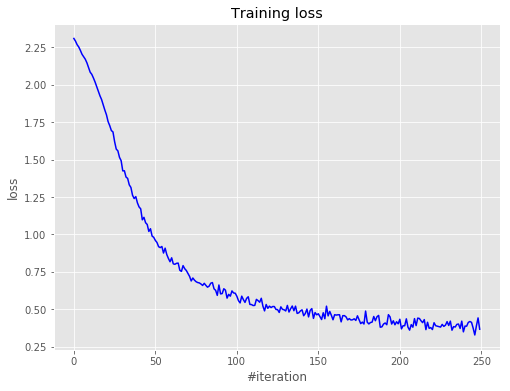

Wall time: 56.2 s


In [215]:
%%time
batch_size = 1000
net_train_(net, n_epoch)

In [216]:
print('Accuracy on test set:   {:.2f} %'.format(accuracy_score(net.forward(X_test), y_test) * 100))

Accuracy on test set:   90.01 %


---

In [120]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(SoftPlus())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
SoftPlus
Linear 300 -> 10
SoftMax



epoch: 0
	loss:   0.86
	Accuracy: train:        67.45 %
	Accuracy: validation:   68.21 %
epoch: 1
	loss:   0.36
	Accuracy: train:        88.89 %
	Accuracy: validation:   89.53 %
epoch: 2
	loss:   0.33
	Accuracy: train:        90.84 %
	Accuracy: validation:   91.21 %
epoch: 3
	loss:   0.28
	Accuracy: train:        91.97 %
	Accuracy: validation:   92.19 %
epoch: 4
	loss:   0.27
	Accuracy: train:        92.14 %
	Accuracy: validation:   92.22 %


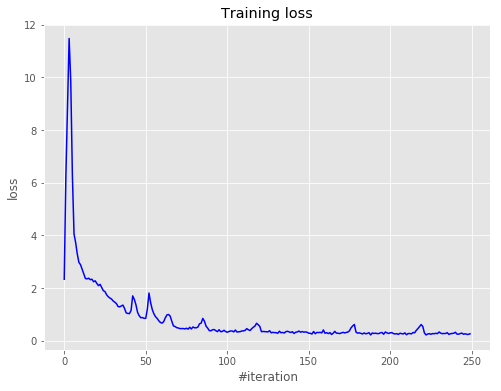

Wall time: 58.9 s


In [121]:
%%time
batch_size = 1000
net_train_(net, n_epoch)

In [122]:
print('Accuracy on test set:   {:.2f} %'.format(accuracy_score(net.forward(X_test), y_test) * 100))

Accuracy on test set:   91.87 %


---

In [193]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 350))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU())
net.add(Linear(350, 100))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(100, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 350
BatchMeanNormalization
LeakyReLU
Linear 350 -> 100
ReLU
Dropout
Linear 100 -> 10
SoftMax



epoch: 0
	loss:   1.17
	Accuracy: train:        11.00 %
	Accuracy: validation:   9.50 %
epoch: 1
	loss:   2.36
	Accuracy: train:        10.70 %
	Accuracy: validation:   9.80 %
epoch: 2
	loss:   2.33
	Accuracy: train:        11.80 %
	Accuracy: validation:   10.30 %
epoch: 3
	loss:   2.30
	Accuracy: train:        10.60 %
	Accuracy: validation:   11.40 %
epoch: 4
	loss:   2.31
	Accuracy: train:        12.30 %
	Accuracy: validation:   10.80 %


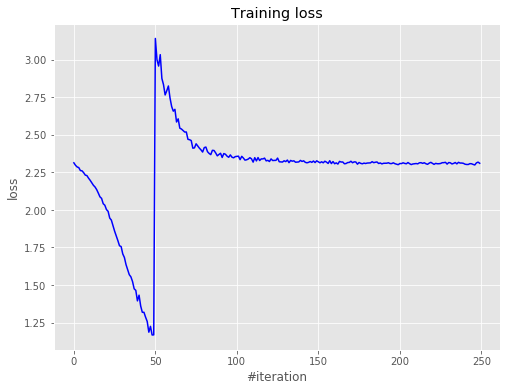

Wall time: 1min 16s


In [194]:
%%time
batch_size = 1000
net_train_(net, n_epoch)

In [195]:
print('Accuracy on test set:   {:.2f} %'.format(accuracy_score(net.forward(X_test), y_test) * 100))

Accuracy on test set:   11.30 %


----

In [210]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 300))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(300, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 300
BatchMeanNormalization
ReLU
Linear 300 -> 10
SoftMax



epoch: 0
	loss:   0.39
	Accuracy: train:        88.17 %
	Accuracy: validation:   88.57 %
epoch: 1
	loss:   0.35
	Accuracy: train:        90.08 %
	Accuracy: validation:   90.54 %
epoch: 2
	loss:   0.31
	Accuracy: train:        91.35 %
	Accuracy: validation:   91.46 %
epoch: 3
	loss:   0.27
	Accuracy: train:        91.99 %
	Accuracy: validation:   92.25 %
epoch: 4
	loss:   0.23
	Accuracy: train:        92.56 %
	Accuracy: validation:   92.66 %


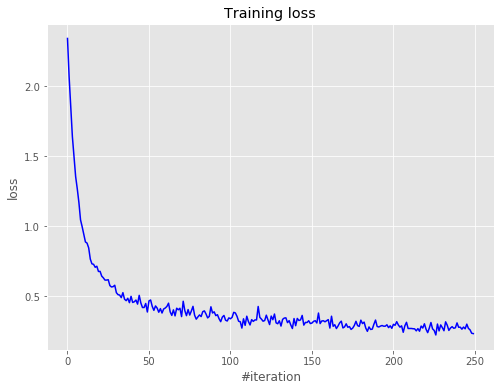

Wall time: 57 s


In [211]:
%%time
batch_size = 1000
net_train_(net, n_epoch)

In [212]:
print('Accuracy on test set:   {:.2f} %'.format(accuracy_score(net.forward(X_test), y_test) * 100))

Accuracy on test set:   92.58 %


---

In [230]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 1000))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(1000, 100))
net.add(LeakyReLU())
net.add(Linear(100, 10))
net.add(SoftMax())

print(net)

Linear 784 -> 1000
BatchMeanNormalization
ReLU
Linear 1000 -> 100
LeakyReLU
Linear 100 -> 10
SoftMax



epoch: 0
	loss:   0.43
	Accuracy: train:        87.81 %
	Accuracy: validation:   88.15 %
epoch: 1
	loss:   0.34
	Accuracy: train:        91.22 %
	Accuracy: validation:   91.70 %
epoch: 2
	loss:   0.24
	Accuracy: train:        92.75 %
	Accuracy: validation:   92.77 %
epoch: 3
	loss:   0.21
	Accuracy: train:        93.57 %
	Accuracy: validation:   93.52 %
epoch: 4
	loss:   0.21
	Accuracy: train:        93.97 %
	Accuracy: validation:   93.88 %


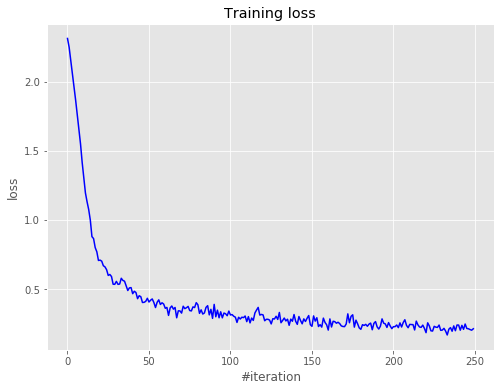

Wall time: 3min 30s


In [223]:
%%time
batch_size = 1000
optimizer_config = {'learning_rate' : 1e-4, 'momentum': 0.9}
optimizer_state = {}

net_train_(net, n_epoch)

In [224]:
print('Accuracy on test set:   {:.2f} %'.format(accuracy_score(net.forward(X_test), y_test) * 100))

Accuracy on test set:   93.76 %


---

---

# Summary

This procedure can go up to infinity... so let's stop here.

Using BatchMeanSubtraction is not increasing the time very much and giving good results

I couldn't find a general rule on what layers to use. However ELU layer wasn't giving good results.

The best accuracy is from this net (considering that we are getting a nice graph for the loss function):
{

Linear 784 -> 1000

BatchMeanNormalization

ReLU

Linear 1000 -> 100

LeakyReLU

Linear 100 -> 10

SoftMax  }


Accuracy on test set:   93.76 %, using batch size 1000, and learning rate 0.0001



---

# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](../imgs/autoencoder.png)

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [17]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [1]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [ ]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################